In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Instalar las bibliotecas necesarias
!pip install -q transformers scikit-learn datasets evaluate optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 18.8 MB/s eta 0:00:00


In [ ]:
# 📊 Procesamiento y manejo de datos
import pandas as pd
import numpy as np
import json
import re

# 🔢 Preprocesamiento y métricas
from sklearn.preprocessing import LabelEncoder
import evaluate

# 📚 Carga de datasets
import pandas as pd
from datasets import Dataset, DatasetDict, load_dataset


# Modelos y entrenamiento con Hugging Face
from transformers import (
    T5ForConditionalGeneration,
    T5TokenizerFast,
    T5Config,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback,
)

# 🧪 Optimización
import optuna

# 🔥 PyTorch
import torch
from torch.utils.data import DataLoader


import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [ ]:
# Check that pyTorch is identifying the GPU
if torch.cuda.device_count() > 0:
  print(f'GPU detected. Currently using: "{torch.cuda.get_device_name(0)}"')
else:
  raise Exception('Currently using CPU, change the type of the runtime in the \'runtime\' tab')

GPU detected. Currently using: "Tesla T4"


# Preprocess Data

In [ ]:
# Paths
train_data_path = '/content/drive/MyDrive/TFG/data/train_data.csv'
test_data_path = '/content/drive/MyDrive/TFG/data/test_data.csv'
valid_data_path = '/content/drive/MyDrive/TFG/data/validation_data.csv'
save_path = '/content/drive/MyDrive/TFG/models'
model_name = 't5-small'
tokenizer  = T5TokenizerFast.from_pretrained(model_name)
prefix = "Clasifica: "

# ——————————————————————————————————————————————————————————
# 3) Cargar CSVs y crear Dataset de Hugging Face
# ——————————————————————————————————————————————————————————
train_df = pd.read_csv(train_data_path).loc[:, ['text', 'intent']]
valid_df = pd.read_csv(valid_data_path).loc[:, ['text', 'intent']]
test_df  = pd.read_csv(test_data_path).loc[:, ['text', 'intent']]

train_ds = Dataset.from_pandas(train_df)
valid_ds = Dataset.from_pandas(valid_df)
test_ds  = Dataset.from_pandas(test_df)

# ——————————————————————————————————————————————————————————
# 4) LabelEncoder para convertir texto-etiqueta → entero (solo para matriz de confusión)
# ——————————————————————————————————————————————————————————
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_ds["intent"])

def encode_labels(example):
    example["label_id"] = int(le.transform([example["intent"]])[0])
    return example

train_ds = train_ds.map(encode_labels)
valid_ds = valid_ds.map(encode_labels)
test_ds  = test_ds.map(encode_labels)

# ——————————————————————————————————————————————————————————
# 5) Función de preprocesado (tokenización de inputs y etiquetas)
# ——————————————————————————————————————————————————————————
def preprocess_data(examples):
    inputs = [prefix + txt for txt in examples["text"]]
    model_inputs = tokenizer(
        inputs,
        max_length=128,
        padding='max_length',
        truncation=True
    )
    # Tokenizar label (p. ej. “add”, “remove”, etc.), poner -100 en pad
    targets = examples["intent"]
    labels = tokenizer(
        text_target=targets,
        max_length=10,
        padding='max_length',
        truncation=True
    )
    model_inputs["labels"] = [
        [(tid if tid != tokenizer.pad_token_id else -100) for tid in label_ids]
        for label_ids in labels["input_ids"]
    ]
    return model_inputs

train_ds = train_ds.map(preprocess_data, batched=True, remove_columns=["text", "intent", "label_id"])
valid_ds = valid_ds.map(preprocess_data, batched=True, remove_columns=["text", "intent", "label_id"])
test_ds  = test_ds.map(preprocess_data, batched=True, remove_columns=["text", "intent", "label_id"])

# 2) Cargar el modelo usando esa configuración modificada

model = T5ForConditionalGeneration.from_pretrained("t5-small")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Map:   0%|          | 0/1960 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

Map:   0%|          | 0/1960 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# Define metrics

In [ ]:
# Función para calcular métricas a partir de una matriz de confusión
def compute_metrics_from_confusion(cm, class_names):
    """
    cm: numpy.ndarray de forma (k, k), matriz de confusión
    class_names: lista de nombres de clases de longitud k
    Devuelve: diccionario con accuracy, precisión/recall/f1 por clase, y promedios macro, micro y weighted.
    """
    k = cm.shape[0]
    # Total de ejemplos
    total = np.sum(cm)
    # True Positives por clase
    tp = np.diag(cm).astype(float)
    # False Positives por clase
    fp = np.sum(cm, axis=0).astype(float) - tp
    # False Negatives por clase
    fn = np.sum(cm, axis=1).astype(float) - tp

    # Precision por clase: TP / (TP + FP)
    precision_per_class = np.zeros(k, dtype=float)
    np.divide(tp, tp + fp, out=precision_per_class, where=(tp + fp) != 0)

    # Recall por clase: TP / (TP + FN)
    recall_per_class = np.zeros(k, dtype=float)
    np.divide(tp, tp + fn, out=recall_per_class, where=(tp + fn) != 0)

    # F1 por clase: 2 * P * R / (P + R)
    f1_per_class = np.zeros(k, dtype=float)
    numerator = 2 * precision_per_class * recall_per_class
    denominator = precision_per_class + recall_per_class
    np.divide(numerator, denominator, out=f1_per_class, where=denominator != 0)

    # Accuracy global
    accuracy = np.sum(tp) / total if total > 0 else 0.0

    # Micro metrics (suma TP, FP, FN)
    tp_micro = np.sum(tp)
    fp_micro = np.sum(fp)
    fn_micro = np.sum(fn)
    precision_micro = tp_micro / (tp_micro + fp_micro) if (tp_micro + fp_micro) > 0 else 0.0
    recall_micro = tp_micro / (tp_micro + fn_micro) if (tp_micro + fn_micro) > 0 else 0.0
    f1_micro = (2 * precision_micro * recall_micro / (precision_micro + recall_micro)
                if (precision_micro + recall_micro) > 0 else 0.0)

    # Macro metrics (promedio simple)
    precision_macro = np.mean(precision_per_class)
    recall_macro = np.mean(recall_per_class)
    f1_macro = np.mean(f1_per_class)

    # Weighted metrics (ponderado por soporte de cada clase)
    support = np.sum(cm, axis=1).astype(float)  # número de ejemplos reales por clase
    weights = support / total
    precision_weighted = np.sum(precision_per_class * weights)
    recall_weighted = np.sum(recall_per_class * weights)
    f1_weighted = np.sum(f1_per_class * weights)

    metrics = {
        "accuracy": accuracy,
        "per_class": {
            class_names[i]: {
                "precision": precision_per_class[i],
                "recall": recall_per_class[i],
                "f1": f1_per_class[i],
                "support": int(support[i])
            } for i in range(k)
        },
        "macro_avg": {
            "precision": precision_macro,
            "recall": recall_macro,
            "f1": f1_macro
        },
        "micro_avg": {
            "precision": precision_micro,
            "recall": recall_micro,
            "f1": f1_micro
        },
        "weighted_avg": {
            "precision": precision_weighted,
            "recall": recall_weighted,
            "f1": f1_weighted
        }
    }
    return metrics

# Training

In [ ]:
def objective(trial):

    # Sugerir hiperparámetros
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    weight_decay = trial.suggest_float("weight_decay", 0.01, 0.2)
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.1, 0.3)

    training_args = TrainingArguments(
        output_dir="optuna_t5",
        num_train_epochs=10,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=warmup_ratio,
        weight_decay=weight_decay,
        learning_rate=learning_rate,
        eval_strategy="epoch",
        save_strategy="epoch",  # 💾 Guarda el modelo cada época
        save_total_limit=2,  # 📦 Solo guarda los 2 últimos modelos (ahorra espacio)
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        logging_dir="logs_t5_final",
        logging_steps=50,
        fp16=True,  # Usar fp16 solo si hay GPU
        lr_scheduler_type="cosine",
        max_grad_norm=1.0
    )

    # 2) Cargar el modelo usando esa configuración modificada
    model = T5ForConditionalGeneration.from_pretrained("t5-small")

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        tokenizer=tokenizer,
        compute_metrics=None,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

    trainer.train()

    eval_result = trainer.evaluate()
    return eval_result["eval_loss"]  # Minimizar la pérdida


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("✅ Mejores hiperparámetros encontrados:")
print(study.best_params)

output_dir_final = f"/content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}_eval_loss"
os.makedirs(output_dir_final, exist_ok=True)

# Guardar los mejores hiperparámetros en un archivo JSON
params_path = f"/content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}_eval_loss/T5_eval_loss_best_params.json"
with open(params_path, "w") as f:
    json.dump(study.best_params, f, indent=4)
print(f"✅ Mejores hiperparámetros guardados en: {params_path}")

import optuna.visualization as vis

# Visualizar el gráfico de optimización de Optuna
fig = vis.plot_optimization_history(study)
fig.show()

# Visualizar el gráfico de importancia de los hiperparámetros
fig = vis.plot_param_importances(study)
fig.show()

# —————————————————————————————————————————————————————————————————————————
# 8) Construir DataLoader para test_ds y generar predicciones con `model.generate(...)`
# —————————————————————————————————————————————————————————————————————————
data_collator = DataCollatorForSeq2Seq(tokenizer, model=None)

# NOTA: test_ds ya tiene "input_ids", "attention_mask" y "labels" (con -100 en padding).
test_loader = DataLoader(
    test_ds,
    batch_size=study.best_params["batch_size"],
    collate_fn=data_collator
)

all_preds = []
all_labels = []

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    for batch in test_loader:
        # Mover tensores a GPU/CPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        # 8.1 Generar IDs: (batch_size, max_length_ids)
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=10
        )

        # Convertir a CPU y numpy
        gen_ids_np = generated_ids.cpu().numpy()
        all_preds.append(gen_ids_np)

        # 8.2 Recoger etiquetas verdaderas: (batch_size, seq_len)
        label_ids = batch["labels"].cpu().numpy()
        # Sustituir -100 por pad_token_id
        label_ids = np.where(label_ids != -100, label_ids, tokenizer.pad_token_id)
        all_labels.append(label_ids)

# 8.3 Concatena todos los batches
all_preds = np.concatenate(all_preds, axis=0)    # shape (N_test, max_length_ids)
all_labels = np.concatenate(all_labels, axis=0)  # shape (N_test, seq_len_labels)

# —————————————————————————————————————————————————————————————————————————
# 9) Convertir predicciones y etiquetas a listas de IDs y luego decodificar a texto
# —————————————————————————————————————————————————————————————————————————
# 9.1 Decodificar las predicciones generadas
pred_ids_list = all_preds.tolist()  # cada elemento es [id1, id2, ..., idN]
decoded_preds = tokenizer.batch_decode(
    pred_ids_list,
    skip_special_tokens=True
)
decoded_preds = [p.strip() for p in decoded_preds]

# 9.2 Decodificar las etiquetas verdaderas
#     all_labels puede ser 2D o, en casos raros, 3D, así que nos aseguramos:
if all_labels.ndim == 3:
    all_labels = all_labels[:, 0, :]  # tomamos la secuencia 0 si hay 3 dims

labels_ids_list = all_labels.tolist()
decoded_labels = tokenizer.batch_decode(
    labels_ids_list,
    skip_special_tokens=True
)
decoded_labels = [l.strip() for l in decoded_labels]

# A partir de aquí conviertes texto a números y dibujas la matriz de confusión:
true_ints = le.transform(decoded_labels)
pred_ints = le.transform(decoded_preds)

cm = confusion_matrix(true_ints, pred_ints, labels=list(range(len(le.classes_))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title(f"Matriz de confusión — {model_name}")
plt.tight_layout()
plt.show()


[I 2025-06-04 11:25:57,123] A new study created in memory with name: no-name-4f758530-bfc2-48d4-8b85-6cc2760474e9


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

<ipython-input-12-be0af1894937>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: daniellinfon (daniellinfon-university-of-huelva) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,9.438600,10.129343
2,8.606100,7.304735
3,7.251700,6.277858
4,7.111100,6.287677
5,7.335800,6.302604
6,7.213800,6.302587


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


[I 2025-06-04 11:29:41,555] Trial 0 finished with value: 6.277857780456543 and parameters: {'learning_rate': 1.1876137253338592e-05, 'batch_size': 16, 'weight_decay': 0.12952798019872172, 'warmup_ratio': 0.12468007461396567}. Best is trial 0 with value: 6.277857780456543.
<ipython-input-12-be0af1894937>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,9.238700,8.853503
2,7.324700,3.604438
3,4.896100,2.976839
4,4.793500,2.958618
5,4.897600,2.955170
6,4.787300,2.955420
7,4.894200,2.953796
8,4.891400,2.953166
9,4.907800,2.953136
10,4.848900,2.953224


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


[I 2025-06-04 11:33:06,477] Trial 1 finished with value: 2.953136444091797 and parameters: {'learning_rate': 2.833605594461782e-05, 'batch_size': 16, 'weight_decay': 0.18314111370610667, 'warmup_ratio': 0.13271508024304574}. Best is trial 1 with value: 2.953136444091797.
<ipython-input-12-be0af1894937>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,9.575200,10.750182
2,9.170600,9.901405
3,8.859000,9.752416
4,8.863400,9.617428
5,8.810500,9.606845
6,8.805600,9.680796
7,8.904600,9.752899
8,9.087400,9.784712


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


[I 2025-06-04 11:37:14,277] Trial 2 finished with value: 9.606844902038574 and parameters: {'learning_rate': 3.2878873409802985e-06, 'batch_size': 8, 'weight_decay': 0.1439870473731002, 'warmup_ratio': 0.20563630694792678}. Best is trial 1 with value: 2.953136444091797.
<ipython-input-12-be0af1894937>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,9.546900,10.878597
2,9.523300,10.502565
3,9.199700,10.316469
4,9.037000,10.314290
5,9.281400,10.311848
6,9.199400,10.308768
7,9.217700,10.306064
8,9.353300,10.302744
9,9.120200,10.301255
10,8.929600,10.301255


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


[I 2025-06-04 11:40:24,786] Trial 3 finished with value: 10.301255226135254 and parameters: {'learning_rate': 4.2085526679956925e-06, 'batch_size': 16, 'weight_decay': 0.029640502180626124, 'warmup_ratio': 0.2913733045066955}. Best is trial 1 with value: 2.953136444091797.
<ipython-input-12-be0af1894937>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,9.286800,9.176887
2,7.610000,3.762961
3,4.992900,3.050313
4,4.936800,3.048903
5,5.042300,3.045914
6,4.906400,3.044916
7,4.997800,3.043309
8,5.043900,3.042718
9,5.022300,3.041090
10,4.984000,3.041642


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


[I 2025-06-04 11:44:05,000] Trial 4 finished with value: 3.0410900115966797 and parameters: {'learning_rate': 4.294768204924821e-05, 'batch_size': 16, 'weight_decay': 0.1250894859157228, 'warmup_ratio': 0.2293860929001407}. Best is trial 1 with value: 2.953136444091797.
<ipython-input-12-be0af1894937>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,9.399600,9.866945
2,8.302200,5.619095
3,6.312600,4.380430
4,6.214500,4.379048
5,6.389300,4.388075
6,6.290300,4.391140
7,6.394600,4.391190


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


[I 2025-06-04 11:46:45,447] Trial 5 finished with value: 4.379047870635986 and parameters: {'learning_rate': 2.7721987737635472e-05, 'batch_size': 16, 'weight_decay': 0.0537131850697725, 'warmup_ratio': 0.21750682843730346}. Best is trial 1 with value: 2.953136444091797.
<ipython-input-12-be0af1894937>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,9.579400,10.769951
2,9.204900,9.980810
3,8.880500,9.775237
4,8.887400,9.689760
5,8.902000,9.824156
6,8.926100,9.906787
7,9.000000,9.918320


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


[I 2025-06-04 11:50:37,446] Trial 6 finished with value: 9.689760208129883 and parameters: {'learning_rate': 3.3358243831491684e-06, 'batch_size': 8, 'weight_decay': 0.18593575347905142, 'warmup_ratio': 0.22678165358552874}. Best is trial 1 with value: 2.953136444091797.
<ipython-input-12-be0af1894937>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,8.818900,7.582814
2,5.388800,2.810129
3,4.066600,2.112511
4,4.057900,2.110565
5,4.077700,2.111491
6,4.039700,2.110962
7,3.991100,2.110275
8,4.132100,2.110303
9,4.152100,2.109708
10,4.064900,2.109736


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


[I 2025-06-04 11:56:10,135] Trial 7 finished with value: 2.109708309173584 and parameters: {'learning_rate': 2.1367484022986432e-05, 'batch_size': 8, 'weight_decay': 0.08512579037465207, 'warmup_ratio': 0.11494419847043849}. Best is trial 7 with value: 2.109708309173584.
<ipython-input-12-be0af1894937>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,9.510500,10.857614
2,9.465300,10.356260
3,9.242300,9.280051
4,8.885900,8.389250
5,8.223700,8.346936
6,8.292100,8.346299
7,7.487600,8.346112
8,8.169600,8.345370
9,8.242300,8.344932
10,8.186000,8.344894


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


[I 2025-06-04 11:59:07,822] Trial 8 finished with value: 8.344894409179688 and parameters: {'learning_rate': 8.331249876507581e-06, 'batch_size': 32, 'weight_decay': 0.015850056946036556, 'warmup_ratio': 0.27891842226796076}. Best is trial 7 with value: 2.109708309173584.
<ipython-input-12-be0af1894937>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,9.560500,10.794692
2,9.419200,10.148258
3,9.148800,9.333964
4,8.892500,8.787340
5,8.423000,8.737350
6,8.465300,8.730384
7,7.641200,8.723559
8,8.328700,8.717019
9,8.409800,8.712895
10,8.351300,8.709888


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


[I 2025-06-04 12:01:55,254] Trial 9 finished with value: 8.709888458251953 and parameters: {'learning_rate': 4.862042974784199e-06, 'batch_size': 32, 'weight_decay': 0.09745859337885351, 'warmup_ratio': 0.11547675137537428}. Best is trial 7 with value: 2.109708309173584.


✅ Mejores hiperparámetros encontrados:
{'learning_rate': 2.1367484022986432e-05, 'batch_size': 8, 'weight_decay': 0.08512579037465207, 'warmup_ratio': 0.11494419847043849}


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/TFG/models/finetuned_t5-small_eval_loss/T5_eval_loss_best_params.json'

In [ ]:
# —————————————————————————————————————————————————————————————————————————
# 8) Construir DataLoader para test_ds y generar predicciones con `model.generate(...)`
# —————————————————————————————————————————————————————————————————————————
data_collator = DataCollatorForSeq2Seq(tokenizer, model=None)

# NOTA: test_ds ya tiene "input_ids", "attention_mask" y "labels" (con -100 en padding).
test_loader = DataLoader(
    test_ds,
    batch_size=study.best_params["batch_size"],
    collate_fn=data_collator
)

all_preds = []
all_labels = []

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    for batch in test_loader:
        # Mover tensores a GPU/CPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        # 8.1 Generar IDs: (batch_size, max_length_ids)
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=10
        )

        # Convertir a CPU y numpy
        gen_ids_np = generated_ids.cpu().numpy()
        all_preds.append(gen_ids_np)

        # 8.2 Recoger etiquetas verdaderas: (batch_size, seq_len)
        label_ids = batch["labels"].cpu().numpy()
        # Sustituir -100 por pad_token_id
        label_ids = np.where(label_ids != -100, label_ids, tokenizer.pad_token_id)
        all_labels.append(label_ids)

# 8.3 Concatena todos los batches
all_preds = np.concatenate(all_preds, axis=0)    # shape (N_test, max_length_ids)
all_labels = np.concatenate(all_labels, axis=0)  # shape (N_test, seq_len_labels)

# —————————————————————————————————————————————————————————————————————————
# 9) Convertir predicciones y etiquetas a listas de IDs y luego decodificar a texto
# —————————————————————————————————————————————————————————————————————————
# 9.1 Decodificar las predicciones generadas
pred_ids_list = all_preds.tolist()  # cada elemento es [id1, id2, ..., idN]
decoded_preds = tokenizer.batch_decode(
    pred_ids_list,
    skip_special_tokens=True
)
decoded_preds = [p.strip() for p in decoded_preds]

# 9.2 Decodificar las etiquetas verdaderas
#     all_labels puede ser 2D o, en casos raros, 3D, así que nos aseguramos:
if all_labels.ndim == 3:
    all_labels = all_labels[:, 0, :]  # tomamos la secuencia 0 si hay 3 dims

labels_ids_list = all_labels.tolist()
decoded_labels = tokenizer.batch_decode(
    labels_ids_list,
    skip_special_tokens=True
)
decoded_labels = [l.strip() for l in decoded_labels]

# A partir de aquí conviertes texto a números y dibujas la matriz de confusión:
true_ints = le.transform(decoded_labels)
pred_ints = le.transform(decoded_preds)

cm = confusion_matrix(true_ints, pred_ints, labels=list(range(len(le.classes_))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title(f"Matriz de confusión — {model_name}")
plt.tight_layout()
plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


✅ Mejores hiperparámetros guardados en: /content/drive/MyDrive/TFG/models/finetuned_t5-small_eval_loss/T5_eval_loss_best_params.json


ValueError: y contains previously unseen labels: np.str_('Clasif')

# Metrics Valid

In [ ]:
# Ejemplo de uso con una matriz de confusión de ejemplo
class_names = ["add", "remove", "view", "clear"]
cm_example = np.array([
    [103,  1,  1,  0],
    [ 0, 101,  3,  1],
    [ 1,  8, 96,  0],
    [ 0,  6,  2, 97]
])

metrics = compute_metrics_from_confusion(cm_example, class_names)

# Mostrar resultados en un DataFrame
df_per_class = pd.DataFrame(metrics["per_class"]).T
df_summary = pd.DataFrame({
    "metric": ["accuracy",
               "precision_macro", "recall_macro", "f1_macro",
               "precision_micro", "recall_micro", "f1_micro",
               "precision_weighted", "recall_weighted", "f1_weighted"],
    "value": [
        metrics["accuracy"],
        metrics["macro_avg"]["precision"],
        metrics["macro_avg"]["recall"],
        metrics["macro_avg"]["f1"],
        metrics["micro_avg"]["precision"],
        metrics["micro_avg"]["recall"],
        metrics["micro_avg"]["f1"],
        metrics["weighted_avg"]["precision"],
        metrics["weighted_avg"]["recall"],
        metrics["weighted_avg"]["f1"]
    ]
})

print("Métricas por clase:")
display(df_per_class)
print("\nResumen de métricas globales:")
display(df_summary)

# Save Model

In [ ]:
# ——————————————————————————————————————————————————————————
# 1) Cargar mejores hiperparámetros desde JSON
# ——————————————————————————————————————————————————————————
params_path = f"/content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}_eval_loss/T5_loss_best_params.json"
with open(params_path, "r") as f:
    best_params = json.load(f)
print("✅ Mejores hiperparámetros:", best_params)

# ——————————————————————————————————————————————————————————
# 2) Rutas a CSV y tokenizador
# ——————————————————————————————————————————————————————————
train_data_path = '/content/drive/MyDrive/TFG/data/train_data.csv'
valid_data_path = '/content/drive/MyDrive/TFG/data/validation_data.csv'
test_data_path  = '/content/drive/MyDrive/TFG/data/test_data.csv'

model_name = 't5-small'
tokenizer  = T5TokenizerFast.from_pretrained(model_name)
prefix = "Clasifica: "

# ——————————————————————————————————————————————————————————
# 3) Cargar CSVs y crear Dataset de Hugging Face
# ——————————————————————————————————————————————————————————
train_df = pd.read_csv(train_data_path).loc[:, ['text', 'intent']]
valid_df = pd.read_csv(valid_data_path).loc[:, ['text', 'intent']]
test_df  = pd.read_csv(test_data_path).loc[:, ['text', 'intent']]

train_ds = Dataset.from_pandas(train_df)
valid_ds = Dataset.from_pandas(valid_df)
test_ds  = Dataset.from_pandas(test_df)

# ——————————————————————————————————————————————————————————
# 4) LabelEncoder para convertir texto-etiqueta → entero (solo para matriz de confusión)
# ——————————————————————————————————————————————————————————
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_ds["intent"])

def encode_labels(example):
    example["label_id"] = int(le.transform([example["intent"]])[0])
    return example

train_ds = train_ds.map(encode_labels)
valid_ds = valid_ds.map(encode_labels)
test_ds  = test_ds.map(encode_labels)

# ——————————————————————————————————————————————————————————
# 5) Función de preprocesado (tokenización de inputs y etiquetas)
# ——————————————————————————————————————————————————————————
def preprocess_data(examples):
    inputs = [prefix + txt for txt in examples["text"]]
    model_inputs = tokenizer(
        inputs,
        max_length=128,
        padding='max_length',
        truncation=True
    )
    # Tokenizar label (p. ej. “add”, “remove”, etc.), poner -100 en pad
    targets = examples["intent"]
    labels = tokenizer(
        text_target=targets,
        max_length=10,
        padding='max_length',
        truncation=True
    )
    model_inputs["labels"] = [
        [(tid if tid != tokenizer.pad_token_id else -100) for tid in label_ids]
        for label_ids in labels["input_ids"]
    ]
    return model_inputs

train_ds = train_ds.map(preprocess_data, batched=True, remove_columns=["text", "intent", "label_id"])
valid_ds = valid_ds.map(preprocess_data, batched=True, remove_columns=["text", "intent", "label_id"])
test_ds  = test_ds.map(preprocess_data, batched=True, remove_columns=["text", "intent", "label_id"])

# ——————————————————————————————————————————————————————————
# 6) Preparar TrainingArguments con los mejores parámetros
# ——————————————————————————————————————————————————————————

training_args = TrainingArguments(
    output_dir="results",
    num_train_epochs=10,
    per_device_train_batch_size=best_params["batch_size"],
    per_device_eval_batch_size=best_params["batch_size"],
    warmup_ratio=best_params["warmup_ratio"],
    weight_decay=best_params["weight_decay"],
    learning_rate=best_params["learning_rate"],
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=torch.cuda.is_available(),
    logging_dir= f"/content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}_eval_loss/logs",
    logging_steps=50,
    lr_scheduler_type="cosine",
    max_grad_norm=1.0,
)

# ——————————————————————————————————————————————————————————
# 7) Crear modelo y Trainer (sin compute_metrics)
# ——————————————————————————————————————————————————————————

model = T5ForConditionalGeneration.from_pretrained(model_name)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=None),
    compute_metrics=None,  # no queremos calcular métricas automáticas
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


# ——————————————————————————————————————————————————————————
# 8) Entrenar
# ——————————————————————————————————————————————————————————
trainer.train()

test_results = trainer.evaluate(test_ds)

print("Resultados en test:", test_results)

# ✅ Guardar el modelo y el tokenizer
model_path = f"/content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}_eval_loss"
trainer.model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
print(f"✅ Modelo guardado correctamente en: {model_path}")


✅ Mejores hiperparámetros: {'learning_rate': 2.1367484022986432e-05, 'batch_size': 8, 'weight_decay': 0.08512579037465207, 'warmup_ratio': 0.11494419847043849}


Map:   0%|          | 0/1960 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

Map:   0%|          | 0/1960 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

<ipython-input-8-356e335297c7>:106: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: daniellinfon (daniellinfon-university-of-huelva) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,5.048800,2.173393
2,0.506500,0.220401
3,0.275200,0.127281
4,0.177400,0.088266
5,0.120900,0.062510
6,0.102800,0.061147
7,0.077600,0.052354
8,0.091700,0.044454
9,0.079000,0.043382
10,0.078200,0.043728


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Resultados en test: {'eval_loss': 0.048345644026994705, 'eval_runtime': 1.3131, 'eval_samples_per_second': 319.864, 'eval_steps_per_second': 40.364, 'epoch': 10.0}
✅ Modelo guardado correctamente en: /content/drive/MyDrive/TFG/models/finetuned_t5-small_eval_loss


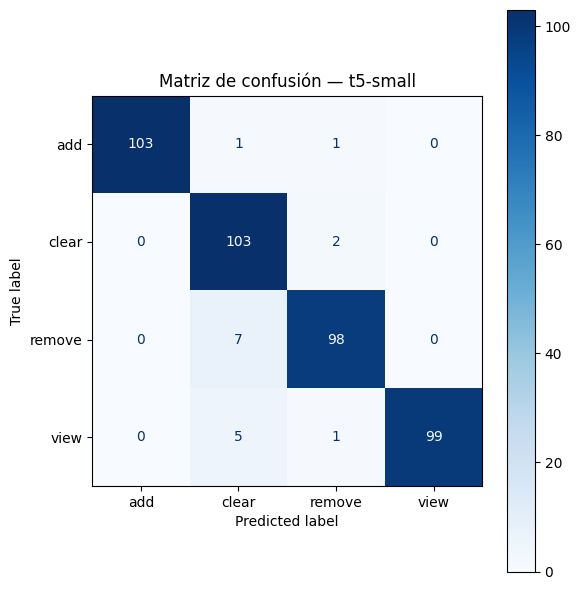

✅ Matriz de confusión guardada en: /content/drive/MyDrive/TFG/models/finetuned_t5-small_eval_loss/confusion_matrix_t5-small.png
Accuracy:  0.9595
Precision: 0.9622
Recall:    0.9595
F1-score:  0.9600
Clase add: precision=1.0000, recall=0.9810, f1=0.9904, support=105
Clase clear: precision=0.8879, recall=0.9810, f1=0.9321, support=105
Clase remove: precision=0.9608, recall=0.9333, f1=0.9469, support=105
Clase view: precision=1.0000, recall=0.9429, f1=0.9706, support=105


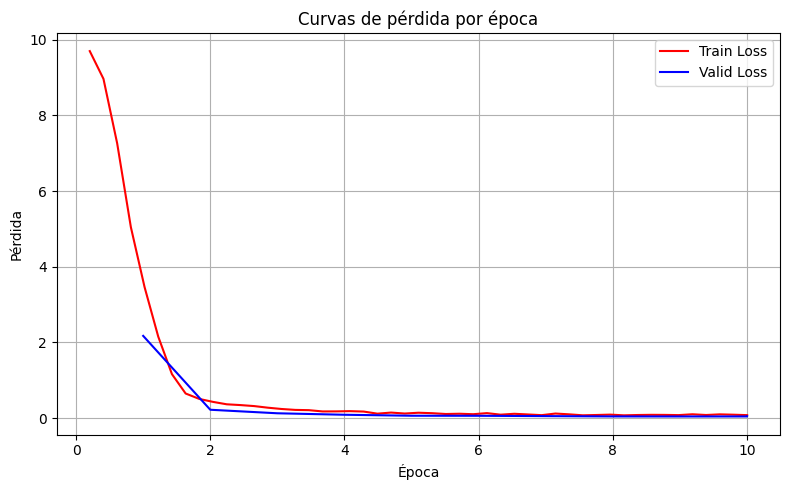

✅ Curvas de pérdida guardadas en: /content/drive/MyDrive/TFG/models/finetuned_t5-small_eval_loss/loss_curves_t5-small.png


In [ ]:
# —————————————————————————————————————————————————————————————————————————
# 8) Construir DataLoader para test_ds y generar predicciones con `model.generate(...)`
# —————————————————————————————————————————————————————————————————————————
data_collator = DataCollatorForSeq2Seq(tokenizer, model=None)

# NOTA: test_ds ya tiene "input_ids", "attention_mask" y "labels" (con -100 en padding).
test_loader = DataLoader(
    test_ds,
    batch_size=best_params["batch_size"],
    collate_fn=data_collator
)

all_preds = []
all_labels = []

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    for batch in test_loader:
        # Mover tensores a GPU/CPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        # 8.1 Generar IDs: (batch_size, max_length_ids)
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=10
        )

        # Convertir a CPU y numpy
        gen_ids_np = generated_ids.cpu().numpy()
        all_preds.append(gen_ids_np)

        # 8.2 Recoger etiquetas verdaderas: (batch_size, seq_len)
        label_ids = batch["labels"].cpu().numpy()
        # Sustituir -100 por pad_token_id
        label_ids = np.where(label_ids != -100, label_ids, tokenizer.pad_token_id)
        all_labels.append(label_ids)

# 8.3 Concatena todos los batches
all_preds = np.concatenate(all_preds, axis=0)    # shape (N_test, max_length_ids)
all_labels = np.concatenate(all_labels, axis=0)  # shape (N_test, seq_len_labels)

# —————————————————————————————————————————————————————————————————————————
# 9) Convertir predicciones y etiquetas a listas de IDs y luego decodificar a texto
# —————————————————————————————————————————————————————————————————————————
# 9.1 Decodificar las predicciones generadas
pred_ids_list = all_preds.tolist()  # cada elemento es [id1, id2, ..., idN]
decoded_preds = tokenizer.batch_decode(
    pred_ids_list,
    skip_special_tokens=True
)
decoded_preds = [p.strip() for p in decoded_preds]

# 9.2 Decodificar las etiquetas verdaderas
#     all_labels puede ser 2D o, en casos raros, 3D, así que nos aseguramos:
if all_labels.ndim == 3:
    all_labels = all_labels[:, 0, :]  # tomamos la secuencia 0 si hay 3 dims

labels_ids_list = all_labels.tolist()
decoded_labels = tokenizer.batch_decode(
    labels_ids_list,
    skip_special_tokens=True
)
decoded_labels = [l.strip() for l in decoded_labels]

# —————————————————————————————————————————————————————————————————————————
# 10) Construir matriz de confusión
# —————————————————————————————————————————————————————————————————————————
true_ints = le.transform(decoded_labels)
pred_ints = le.transform(decoded_preds)

class_names = list(le.classes_)  # p.ej. ["add","clear","remove","view"]
cm = confusion_matrix(true_ints, pred_ints, labels=list(range(len(class_names))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title(f"Matriz de confusión — {model_name}")
plt.tight_layout()

cm_path = f"/content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}_eval_loss/confusion_matrix_{model_name.replace('/', '_')}.png"
plt.savefig(cm_path)
plt.show()
print(f"✅ Matriz de confusión guardada en: {cm_path}")

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# true_ints y pred_ints son array-like de forma (N,)
# donde cada elemento es un entero en [0, num_clases-1].

# 1) Accuracy
acc = accuracy_score(true_ints, pred_ints)

# 2) Precision, Recall y F1. Como es multiclasificación,
#    conviene especificar average="weighted" (o "macro"):

precision = precision_score(true_ints, pred_ints, average="weighted")
recall    = recall_score(true_ints, pred_ints, average="weighted")
f1        = f1_score(true_ints, pred_ints, average="weighted")

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

from sklearn.metrics import precision_recall_fscore_support

# precision_recall_fscore_support devuelve (prec_per_clase, rec_per_clase, f1_per_clase, support)
prec_per_class, rec_per_class, f1_per_class, support = \
    precision_recall_fscore_support(true_ints, pred_ints, average=None)

for i, cls in enumerate(le.classes_):
    print(f"Clase {cls}: precision={prec_per_class[i]:.4f}, recall={rec_per_class[i]:.4f}, f1={f1_per_class[i]:.4f}, support={support[i]}")


# —————————————————————————————————————————————————————————————————————————
# 11) Graficar curvas de pérdida (train vs validación)
# —————————————————————————————————————————————————————————————————————————
log_history = trainer.state.log_history
train_logs = [e for e in log_history if ("loss" in e and "eval_loss" not in e and "epoch" in e)]
eval_logs  = [e for e in log_history if "eval_loss" in e]

df_train = pd.DataFrame(train_logs)
df_eval  = pd.DataFrame(eval_logs)

plt.figure(figsize=(8,5))
if not df_train.empty:
    train_loss_by_epoch = df_train.groupby("epoch")["loss"].mean()
    plt.plot(train_loss_by_epoch.index, train_loss_by_epoch.values, label="Train Loss", color="red")

if not df_eval.empty:
    plt.plot(df_eval["epoch"], df_eval["eval_loss"], label="Valid Loss", color="blue")

plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Curvas de pérdida por época")
plt.legend()
plt.grid(True)
plt.tight_layout()

loss_curve_path = f"/content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}_eval_loss/loss_curves_{model_name.replace('/', '_')}.png"
plt.savefig(loss_curve_path)
plt.show()
print(f"✅ Curvas de pérdida guardadas en: {loss_curve_path}")


# Metrics Test


In [ ]:
# Ejemplo de uso con una matriz de confusión de ejemplo
class_names = ["add", "remove", "view", "clear"]
cm_example = np.array([
    [103,  1,  1,  0],
    [ 0, 103,  2,  0],
    [ 0,  7, 98,  0],
    [ 0,  5,  1, 99]
])

metrics = compute_metrics_from_confusion(cm_example, class_names)

# Mostrar resultados en un DataFrame
df_per_class = pd.DataFrame(metrics["per_class"]).T
df_summary = pd.DataFrame({
    "metric": ["accuracy",
               "precision_macro", "recall_macro", "f1_macro",
               "precision_micro", "recall_micro", "f1_micro",
               "precision_weighted", "recall_weighted", "f1_weighted"],
    "value": [
        metrics["accuracy"],
        metrics["macro_avg"]["precision"],
        metrics["macro_avg"]["recall"],
        metrics["macro_avg"]["f1"],
        metrics["micro_avg"]["precision"],
        metrics["micro_avg"]["recall"],
        metrics["micro_avg"]["f1"],
        metrics["weighted_avg"]["precision"],
        metrics["weighted_avg"]["recall"],
        metrics["weighted_avg"]["f1"]
    ]
})

print("Métricas por clase:")
display(df_per_class)
print("\nResumen de métricas globales:")
display(df_summary)

# 5) Guardar en CSV y JSON
# 5.1 Guardar df_per_class en CSV
df_per_class.to_csv(f"/content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}_eval_loss/metrics_per_class.csv", index=True)
print(f"✅ Métricas por clase guardadas en /content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}_eval_loss/metrics_per_class.csv")

# 5.2 Guardar df_summary en CSV
df_summary.to_csv(f"/content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}_eval_loss/metrics_summary.csv", index=False)
print(f"✅ Resumen de métricas guardado en /content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}_eval_loss/metrics_summary.csv")


Métricas por clase:


,precision,recall,f1,support
add,1.000000,0.980952,0.990385,105.0
remove,0.887931,0.980952,0.932127,105.0
view,0.960784,0.933333,0.946860,105.0
clear,1.000000,0.942857,0.970588,105.0



Resumen de métricas globales:


,metric,value
0,accuracy,0.959524
1,precision_macro,0.962179
2,recall_macro,0.959524
3,f1_macro,0.959990
4,precision_micro,0.959524
5,recall_micro,0.959524
6,f1_micro,0.959524
7,precision_weighted,0.962179
8,recall_weighted,0.959524
9,f1_weighted,0.959990


✅ Métricas por clase guardadas en /content/drive/MyDrive/TFG/models/finetuned_t5-small_eval_loss/metrics_per_class.csv
✅ Resumen de métricas guardado en /content/drive/MyDrive/TFG/models/finetuned_t5-small_eval_loss/metrics_summary.csv
